<a href="https://colab.research.google.com/github/rohinimishraCD/highcharts/blob/master/random_forrest_model_training_of_yocket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [ ]:
! pip install h2o

     |████████████████████████████████| 129.4MB 99kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.3-py2.py3-none-any.whl size=129446676 sha256=e38ff5878ea5ec656289c2793adaacea1f2aa75943f59d9dd2cb884b883092ca
  Stored in directory: /root/.cache/pip/wheels/3d/e6/07/53ce9be9cb61b33a79cb3ed1fc39f2dae84f6ee6fe1e373e5e
Successfully built h2o


In [ ]:
import h2o
import h2o
import os
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import seaborn as sns
import time, sys
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
file_path = '/content/gdrive/My Drive/Colab Notebooks/data/basic_outlier_removal_with_normaliation_and_keeping_course_of_at_30_points.csv'
# file_path = '/content/gdrive/My Drive/Colab Notebooks/data/outlier_removal_with_normaliation_and_keeping_course_of_at_30_points.csv'
file = pd.read_csv(file_path)
file.drop(columns=['Unnamed: 0','Year','Percentage','CGPA',],inplace=True)
feature_columns = list(file.columns)
feature_columns.remove('status')


# file = file[['collegename', 'city', 'state', 'course name', 'Major course', 'gre', 'work ex', 'Ielts','Toefl', 'norm_cgpa_per','status']]

target = 'status'
print(feature_columns)
print(file.shape)
file.describe()
file.head()

['collegename', 'city', 'state', 'course name', 'Major course', 'gre', 'work ex', 'Ielts', 'Toefl', 'norm_cgpa_per']
(140596, 11)


,collegename,status,city,state,course name,Major course,gre,work ex,Ielts,Toefl,norm_cgpa_per
0,Arkansas State University,Admit,Arkansas,United States,Computer Science,Engineering,299.0,39.0,7.0,NaN,70.00
1,Arkansas State University,Admit,Arkansas,United States,Computer Science,Engineering,305.0,13.0,NaN,87.0,7.13
2,Arkansas State University,Reject,Arkansas,United States,Computer Science,Engineering,297.0,28.0,6.5,NaN,8.90
3,Arkansas State University,Admit,Arkansas,United States,Computer Science,Engineering,295.0,28.0,NaN,76.0,6.76
4,Arkansas State University,Admit,Arkansas,United States,Computer Science,Engineering,294.0,1.0,6.0,NaN,8.52


In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 30 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,"21 days, 17 hours and 51 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_gxp50l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.263 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
feature_columns = feature_columns
response_column = target


def Get_Model_Data():
    global x_train, y_train, x_valid, y_valid, x_test, y_test
    global train, valid, test 
    global feature_columns, response_column
    
    model = h2o.H2OFrame(file)
    
    mask = feature_columns+[response_column]
    
    
    df_new = model[mask].as_data_frame()
    plt.ioff()
    red_green = ["#ff0000", "#00ff00"]
    sns.set_palette(red_green)
    np.seterr(divide='ignore', invalid='ignore')
    g = sns.pairplot(df_new,
                     diag_kind='kde',
                     hue=response_column, 
                     markers=["o", "D"],
                     size=1.5,
                     aspect=1,
                     plot_kws={"s": 10})
    g.fig.subplots_adjust(right=0.9)
    plt.show()
    

    # Split the data into Train/Validation/Test with Train having 70% and test and validation 15% each
    train_full, valid_full, test_full = model.split_frame(ratios=[.7, .15])


    train_ = train_full[mask].as_data_frame(use_pandas=True, header=True)
    valid_ = valid_full[mask].as_data_frame(use_pandas=True, header=True)
    test_  = test_full[mask].as_data_frame(use_pandas=True, header=True)
    print('train_: \n', train_.head(5))
    print('valid_: \n', valid_.head(5))
    print('test_: \n',  test_.head(5))

    x_train = train_full[feature_columns]
    y_train = train_full[response_column].asfactor()
    x_valid = valid_full[feature_columns]
    y_valid = valid_full[response_column].asfactor()
    x_test  = test_full[feature_columns]
    y_test  = test_full[response_column].asfactor()
    
    train = train_full[mask]
    train[response_column] = y_train
    valid = valid_full[mask]
    valid[response_column] = y_valid
    test  = test_full[mask]
    test[response_column] = y_test

    return


In [ ]:
def ROC_Curve(model, df):
    performance = model.model_performance(df)
    auc = performance.auc()
    false_positive_rate = performance.fprs
    true_positive_rate = performance.tprs

    plt.style.use('ggplot')
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, 'k--')
    plt.plot(false_positive_rate, 
             true_positive_rate, 
             color='darkorange',
             lw = 2,
             label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    

In [ ]:
#Plot the performance of each predictor
def Plot_predictor_importance(saved_rf):
    fig, ax = plt.subplots()
    variables = saved_rf._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    scaled_importance = saved_rf._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos, 
            scaled_importance, 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

In [ ]:
def Print_Metrics(model):
    print('\nModel performance on validate and test data set:')
    performance_valid = model.model_performance(valid)
    # accuracy, precision and F1 produce two numbers, which are the threshold and the value respectively.
    # we index them to extract just the value.
    mse             = performance_valid.mse()
    logloss_valid   = performance_valid.logloss()
    accuracy_valid  = performance_valid.accuracy()[0][1]
    precision_valid = performance_valid.precision()[0][1]
    F1_valid        = performance_valid.F1()[0][1]
    r2_valid        = performance_valid.r2()
    auc_valid       = performance_valid.auc()
    
    predictions = model.predict(x_test)
    accuracy = (predictions['predict'] == y_test).as_data_frame(use_pandas=True).mean()
    print('Percent correct predictions on test set (accuracy): ', accuracy[0])
    
    performance_test = model.model_performance(test)
    mse            = performance_test.mse()
    logloss_test   = performance_test.logloss()
    accuracy_test  = performance_test.accuracy()[0][1]
    precision_test = performance_test.precision()[0][1]
    F1_test        = performance_test.F1()[0][1]
    auc_test       = performance_test.auc()
    r2_test        = performance_test.r2()

    test_auc       = h2o.get_model(model).model_performance(test_data=test).auc()
    print('Best model performance based on auc: ', test_auc)
    
    header = ["Metric", "Validate", "Test"]
    table  = [
               ["logloss",   logloss_valid,   logloss_test],
               ["accuracy",  accuracy_valid,  accuracy_test],
               ["precision", precision_valid, precision_test],
               ["F1",        F1_valid,        F1_test],
               ["r2",        r2_valid,        r2_test],
               ["AUC",       auc_valid,       auc_test]
             ]
    h2o.display.H2ODisplay(table, header)
    

In [ ]:
#Start the h2o server


localH2O = h2o.init(ip = "localhost",
                    port = 54321,
                    max_mem_size="24G",
                    nthreads = 2)
h2o.no_progress()
h2o.remove_all()




Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 30 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,"21 days, 17 hours and 51 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_gxp50l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.263 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


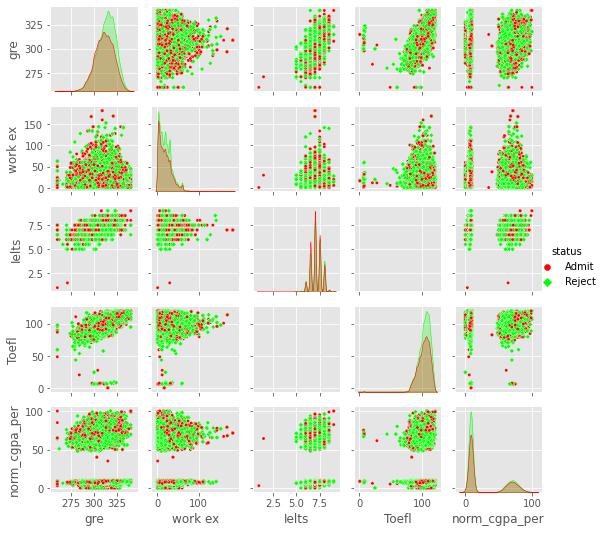

train_: 
                  collegename      city  ... norm_cgpa_per  status
0  Arkansas State University  Arkansas  ...         70.00   Admit
1  Arkansas State University  Arkansas  ...          8.90  Reject
2  Arkansas State University  Arkansas  ...          6.76   Admit
3  Arkansas State University  Arkansas  ...          7.35   Admit
4  Arkansas State University  Arkansas  ...         82.00   Admit

[5 rows x 11 columns]
valid_: 
                  collegename      city  ... norm_cgpa_per  status
0  Arkansas State University  Arkansas  ...          7.13   Admit
1  Arkansas State University  Arkansas  ...          8.52   Admit
2  Arkansas State University  Arkansas  ...         59.60  Reject
3  Arkansas State University  Arkansas  ...          7.27  Reject
4  Arkansas State University  Arkansas  ...          7.00  Reject

[5 rows x 11 columns]
test_: 
                  collegename      city  ... norm_cgpa_per  status
0  Arkansas State University  Arkansas  ...          8.09   Admit
1

In [ ]:
Get_Model_Data()

In [ ]:
# estimator = H2ORandomForestEstimator(
#     # Stops fitting new trees when 10-tree rolling average is within 0.00001
#     stopping_rounds = 10,
#     stopping_tolerance = 0.00001,
#     stopping_metric = 'auto',
#     score_each_iteration = True,
#     balance_classes = True,
#     seed = 7)

# hyper_parameters = {'ntrees':[100,120], 
#                     'max_depth':[13,14,15,16],
#                     ]                 }

# search_criteria = { 'strategy': "RandomDiscrete",
#                     'stopping_metric': "misclassification", 
#                     'stopping_tolerance': 0.001,
#                     'stopping_rounds': 10 }
		    


# grid_search = H2OGridSearch(model = estimator, 
#                             hyper_params = hyper_parameters,
#                             search_criteria = search_criteria)

In [ ]:
# grid_search.train(x = feature_columns,
#                   y = response_column,
#                   training_frame = train,
#                   validation_frame = valid)

In [ ]:
# sorted_grid = grid_search.get_grid(sort_by='auc',decreasing=True)
# # print('Best model sorted by auc:\n', sorted_grid.models[0])

# best_max_depth  = sorted_grid.sorted_metric_table()['max_depth'][0]
# best_ntrees     = sorted_grid.sorted_metric_table()['ntrees'][0]
# best_auc        = sorted_grid.sorted_metric_table()['auc'][0]
# sorted_grid_mse = grid_search.get_grid(sort_by='mse',decreasing=True)
# best_mse        = sorted_grid_mse.sorted_metric_table()['mse'][0]

# print('Best max_depth.....', best_max_depth)
# print('Best ntrees........', best_ntrees)
# print('Best auc...........', best_auc)
# print('Best mse...........', best_mse)

In [ ]:
# sorted_grid.sorted_metric_table()

In [ ]:

best_rf = H2ORandomForestEstimator(
    
    ntrees = 120,
    max_depth = 15,
    nfolds = 20,
    binomial_double_trees= True,
    stopping_rounds = 5,
    score_each_iteration = True,
    seed = 7)

best_rf.train(feature_columns, 
              response_column, 
              training_frame = train, 
              validation_frame = valid)

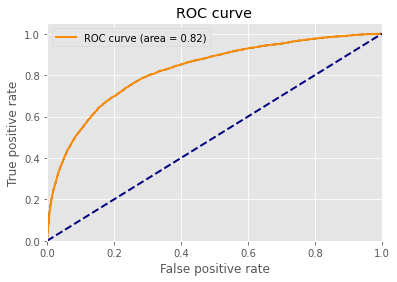

In [ ]:
ROC_Curve(best_rf, valid)

In [ ]:
print('Confusion matrix computed by precision:\n', best_rf.confusion_matrix(metrics='accuracy'))

Confusion matrix computed by precision:
 
Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.5189661040315959: 


,,Admit,Reject,Error,Rate
0,Admit,31658.0,11740.0,0.2705,(11740.0/43398.0)
1,Reject,13136.0,41802.0,0.2391,(13136.0/54938.0)
2,Total,44794.0,53542.0,0.253,(24876.0/98336.0)


In [ ]:
my_mojo = best_rf.download_mojo(path="/content/",get_genmodel_jar=True)

In [ ]:
my_mojo

'/content/DRF_model_python_1603180241767_3985.zip'

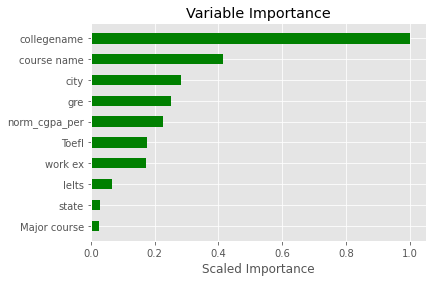

In [ ]:
Plot_predictor_importance(best_rf)

In [ ]:
Print_Metrics(best_rf)


Model performance on validate and test data set:
Percent correct predictions on test set (accuracy):  0.7399697913716605
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1603180241767_3985


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,33.0,66.0,5816474.0,15.0,15.0,15.0,3689.0,5758.0,4993.758




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1718644290565364
RMSE: 0.41456534956088215
LogLoss: 0.5179591724670142
Mean Per-Class Error: 0.2527911621872434
AUC: 0.8201028902313371
AUCPR: 0.8514581363556452
Gini: 0.6402057804626742

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41180491715331563: 


,,Admit,Reject,Error,Rate
0,Admit,25313.0,18085.0,0.4167,(18085.0/43398.0)
1,Reject,7978.0,46960.0,0.1452,(7978.0/54938.0)
2,Total,33291.0,65045.0,0.265,(26063.0/98336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.411805,0.782778,243.0
1,max f2,0.190357,0.869600,339.0
2,max f0point5,0.625896,0.787879,157.0
3,max accuracy,0.518966,0.747031,200.0
4,max precision,0.999304,0.992337,0.0
5,max recall,0.003753,1.000000,399.0
6,max specificity,0.999304,0.999954,0.0
7,max absolute_mcc,0.580646,0.491355,176.0
8,max min_per_class_accuracy,0.533938,0.746117,194.0
9,max mean_per_class_accuracy,0.580646,0.747209,176.0



Gains/Lift Table: Avg response rate: 55.87 %, avg score: 55.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010007,0.987488,1.757202,1.757202,0.981707,0.994557,0.981707,0.994557,0.017583,0.017583,75.720213,75.720213,0.017169
1,2,0.020003,0.976426,1.720751,1.738986,0.961343,0.981732,0.971530,0.988147,0.017201,0.034785,72.075082,73.898574,0.033494
2,3,0.030009,0.968891,1.744469,1.740814,0.974593,0.972549,0.972552,0.982946,0.017456,0.052241,74.446878,74.081404,0.050374
3,4,0.040006,0.961100,1.713467,1.733981,0.957274,0.965058,0.968734,0.978476,0.017128,0.069369,71.346721,73.398081,0.066535
4,5,0.050002,0.953741,1.729855,1.733156,0.966429,0.957422,0.968273,0.974267,0.017292,0.086661,72.985532,73.315605,0.083067
5,6,0.100004,0.915721,1.682556,1.707856,0.940004,0.934872,0.954139,0.954569,0.084131,0.170793,68.255561,70.785583,0.160400
6,7,0.150006,0.875716,1.613754,1.676488,0.901566,0.896032,0.936614,0.935057,0.080691,0.251483,61.375357,67.648841,0.229939
7,8,0.200008,0.833567,1.559877,1.647336,0.871466,0.854805,0.920327,0.914994,0.077997,0.329481,55.987685,64.733552,0.293373
8,9,0.300002,0.746730,1.457368,1.584017,0.814197,0.790269,0.884953,0.873422,0.145728,0.475208,45.736804,58.401732,0.397002
9,10,0.400006,0.656917,1.312335,1.516095,0.733171,0.702449,0.847006,0.830677,0.131239,0.606447,31.233513,51.609504,0.467777




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.17027107142550127
RMSE: 0.4126391540141353
LogLoss: 0.5132137391454744
Mean Per-Class Error: 0.24802577218321653
AUC: 0.8242802065667328
AUCPR: 0.8517065231102502
Gini: 0.6485604131334657

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.455520752834971: 


,,Admit,Reject,Error,Rate
0,Admit,6243.0,3161.0,0.3361,(3161.0/9404.0)
1,Reject,2105.0,9565.0,0.1804,(2105.0/11670.0)
2,Total,8348.0,12726.0,0.2499,(5266.0/21074.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.455521,0.784145,229.0
1,max f2,0.199349,0.868739,341.0
2,max f0point5,0.623177,0.790016,159.0
3,max accuracy,0.492259,0.754247,214.0
4,max precision,0.997289,1.000000,0.0
5,max recall,0.039281,1.000000,396.0
6,max specificity,0.997289,1.000000,0.0
7,max absolute_mcc,0.499475,0.502339,211.0
8,max min_per_class_accuracy,0.528416,0.750471,200.0
9,max mean_per_class_accuracy,0.518666,0.751974,204.0



Gains/Lift Table: Avg response rate: 55.38 %, avg score: 55.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.977986,1.754476,1.754476,0.971564,0.986693,0.971564,0.986693,0.017566,0.017566,75.447638,75.447638,0.016928
1,2,0.020025,0.968305,1.745918,1.750197,0.966825,0.972831,0.969194,0.979762,0.017481,0.035047,74.591796,75.019717,0.033665
2,3,0.030037,0.960201,1.720243,1.740212,0.952607,0.964232,0.963665,0.974585,0.017224,0.052271,72.024269,74.021234,0.049825
3,4,0.040002,0.952411,1.728434,1.737278,0.957143,0.956245,0.962040,0.970017,0.017224,0.069494,72.843432,73.727832,0.066092
4,5,0.050014,0.945359,1.703126,1.730441,0.943128,0.949093,0.958254,0.965828,0.017052,0.086547,70.312585,73.044134,0.081868
5,6,0.100028,0.909883,1.715022,1.722731,0.949715,0.928441,0.953985,0.947134,0.085775,0.172322,71.502157,72.273146,0.162007
6,7,0.149995,0.869059,1.641193,1.695569,0.908832,0.890260,0.938943,0.928188,0.082005,0.254327,64.119311,69.556921,0.233804
7,8,0.200009,0.826000,1.577957,1.666159,0.873814,0.847930,0.922657,0.908119,0.078920,0.333248,57.795691,66.615916,0.298582
8,9,0.299991,0.739910,1.470716,1.601022,0.814428,0.782788,0.886587,0.866348,0.147044,0.480291,47.071617,60.102180,0.404047
9,10,0.400019,0.648281,1.311537,1.528634,0.726281,0.695054,0.846501,0.823515,0.131191,0.611482,31.153747,52.863355,0.473881




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.17049335509180738
RMSE: 0.41290841005216566
LogLoss: 0.5135832367991929
Mean Per-Class Error: 0.24922286656935566
AUC: 0.8234487065478255
AUCPR: 0.8539891422458948
Gini: 0.6468974130956511

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41097659905109374: 


,,Admit,Reject,Error,Rate
0,Admit,25321.0,18077.0,0.4165,(18077.0/43398.0)
1,Reject,7901.0,47037.0,0.1438,(7901.0/54938.0)
2,Total,33222.0,65114.0,0.2642,(25978.0/98336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.410977,0.783610,252.0
1,max f2,0.222820,0.870384,335.0
2,max f0point5,0.634716,0.790070,158.0
3,max accuracy,0.509934,0.749990,210.0
4,max precision,0.998035,1.000000,0.0
5,max recall,0.013149,1.000000,399.0
6,max specificity,0.998035,1.000000,0.0
7,max absolute_mcc,0.541544,0.498475,197.0
8,max min_per_class_accuracy,0.532035,0.749067,201.0
9,max mean_per_class_accuracy,0.541544,0.750777,197.0



Gains/Lift Table: Avg response rate: 55.87 %, avg score: 55.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010017,0.979350,1.737246,1.737246,0.970558,0.987782,0.970558,0.987782,0.017401,0.017401,73.724614,73.724614,0.016733
1,2,0.020003,0.968758,1.742553,1.739896,0.973523,0.973630,0.972039,0.980717,0.017401,0.034803,74.255341,73.989573,0.033536
2,3,0.030009,0.960572,1.744469,1.741421,0.974593,0.964609,0.972891,0.975346,0.017456,0.052259,74.446878,74.142060,0.050416
3,4,0.040006,0.953364,1.722572,1.736711,0.962360,0.956967,0.970259,0.970753,0.017219,0.069478,72.257172,73.671077,0.066782
4,5,0.050002,0.946110,1.717109,1.732792,0.959308,0.949771,0.968070,0.966559,0.017165,0.086643,71.710902,73.279202,0.083025
5,6,0.100004,0.910542,1.682192,1.707492,0.939801,0.928598,0.953935,0.947578,0.084113,0.170756,68.219158,70.749180,0.160318
6,7,0.150006,0.869753,1.631227,1.682070,0.911328,0.890590,0.939733,0.928582,0.081565,0.252321,63.122710,68.207023,0.231836
7,8,0.200008,0.828004,1.569706,1.653979,0.876957,0.848958,0.924039,0.908676,0.078488,0.330809,56.970571,65.397910,0.296384
8,9,0.300002,0.742790,1.467198,1.591723,0.819689,0.785493,0.889258,0.867618,0.146711,0.477520,46.719790,59.172292,0.402240
9,10,0.400006,0.654006,1.312699,1.521965,0.733374,0.699035,0.850286,0.825471,0.131275,0.608795,31.269916,52.196521,0.473098




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid
0,accuracy,0.738871,0.0071839094,0.7375556,0.7465419,0.7376327,0.73569536,0.7311915,0.7321501,0.7500506,0.7416667,0.7430985,0.73001814,0.7316176,0.74336106,0.73431736,0.7413899,0.74264705,0.74179566,0.73437184,0.7503055,0.7479458,0.7240664
1,auc,0.8234401,0.006090232,0.82367903,0.83237,0.814403,0.82113975,0.83100736,0.82448083,0.82938224,0.82569516,0.82884026,0.8266588,0.8196251,0.8210255,0.8199469,0.8348184,0.8285375,0.8166373,0.8173119,0.82226,0.8152997,0.8156829
2,aucpr,0.8540368,0.0073253904,0.85390466,0.86173916,0.84680414,0.85159874,0.86457044,0.84848946,0.8639692,0.85816854,0.86049694,0.8509765,0.85004455,0.85449094,0.8472603,0.86573654,0.858158,0.8594185,0.84306186,0.8399648,0.8486086,0.85327375
3,err,0.26112905,0.0071839094,0.26244435,0.25345808,0.2623673,0.2643046,0.26880845,0.26784995,0.2499494,0.25833333,0.25690153,0.2699819,0.26838234,0.25663897,0.26568267,0.25861016,0.25735295,0.25820434,0.26562816,0.2496945,0.25205424,0.27593362
4,err_count,1283.9,37.017635,1297.0,1246.0,1310.0,1298.0,1322.0,1328.0,1235.0,1302.0,1247.0,1341.0,1314.0,1266.0,1296.0,1269.0,1260.0,1251.0,1313.0,1226.0,1227.0,1330.0
5,f0point5,0.7489114,0.010886329,0.74874145,0.75530875,0.74863183,0.74731815,0.73551565,0.7344403,0.76482147,0.752142,0.7550554,0.73058254,0.73753333,0.75473505,0.74387646,0.74538136,0.7508203,0.7622364,0.74540526,0.7626879,0.7685875,0.7344058
6,f1,0.785446,0.0059238314,0.7837252,0.78773427,0.7880259,0.77880025,0.7934375,0.7921102,0.7908552,0.7906079,0.78781694,0.78219914,0.77967805,0.789,0.780339,0.79396003,0.7874494,0.79076767,0.77451485,0.7790195,0.78240824,0.7764706
7,f2,0.82616013,0.017335223,0.82213825,0.8230687,0.8317961,0.8130515,0.86126184,0.8596086,0.8187237,0.83322036,0.82355034,0.8416638,0.8269313,0.8265242,0.82056034,0.8493122,0.82783574,0.82151794,0.8059904,0.79606575,0.79673505,0.82364684
8,lift_top_group,1.7377943,0.036136456,1.7515949,1.7318752,1.7003477,1.6922067,1.7690648,1.7503026,1.7741473,1.7026558,1.7079521,1.7556406,1.7776433,1.743361,1.727168,1.7876139,1.7613226,1.6932296,1.7433064,1.6519626,1.7798903,1.7546015
9,logloss,0.5135914,0.006837077,0.51397824,0.50322324,0.5234589,0.51602834,0.5035707,0.5126697,0.5053344,0.5109428,0.50743526,0.51112807,0.5183938,0.5165985,0.5185655,0.5007862,0.50996727,0.5167443,0.520725,0.5188546,0.5228119,0.5206117



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-10-20 09:27:09,5 min 26.941 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-10-20 09:27:09,5 min 27.192 sec,1.0,0.473388,3.174409,0.745410,0.754168,1.394509,0.306031,0.470211,3.117495,0.750501,0.753976,1.401343,0.300940
2,,2020-10-20 09:27:09,5 min 27.493 sec,2.0,0.461040,2.468035,0.757440,0.766221,1.406385,0.308202,0.431758,1.000990,0.792773,0.808182,1.531927,0.278590
3,,2020-10-20 09:27:10,5 min 27.842 sec,3.0,0.455452,2.185178,0.764037,0.772374,1.409962,0.299114,0.424786,0.709623,0.803136,0.825082,1.610686,0.276122
4,,2020-10-20 09:27:10,5 min 28.211 sec,4.0,0.448718,1.861748,0.772666,0.782682,1.434344,0.297365,0.420403,0.606633,0.810187,0.835197,1.662682,0.275363
5,,2020-10-20 09:27:11,5 min 28.729 sec,5.0,0.444160,1.619464,0.777737,0.788939,1.446324,0.296251,0.418904,0.561713,0.812497,0.837553,1.677413,0.269716
6,,2020-10-20 09:27:11,5 min 29.119 sec,6.0,0.439007,1.355808,0.783720,0.797762,1.462103,0.286599,0.417539,0.535899,0.814891,0.841526,1.720243,0.265493
7,,2020-10-20 09:27:11,5 min 29.511 sec,7.0,0.434460,1.157759,0.789658,0.805866,1.481371,0.283263,0.416860,0.528310,0.816114,0.842897,1.737682,0.268910
8,,2020-10-20 09:27:12,5 min 29.922 sec,8.0,0.431048,1.011229,0.794101,0.812010,1.497317,0.281846,0.416585,0.526137,0.816637,0.842970,1.737360,0.268198
9,,2020-10-20 09:27:12,5 min 30.366 sec,9.0,0.428827,0.914027,0.797221,0.816592,1.507322,0.279148,0.416138,0.523460,0.817493,0.843577,1.729524,0.264354



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,collegename,197843.359375,1.000000,0.378871
1,course name,82119.468750,0.415073,0.157259
2,city,55821.218750,0.282149,0.106898
3,gre,49785.628906,0.251642,0.095340
4,norm_cgpa_per,44500.550781,0.224928,0.085219
5,Toefl,34750.074219,0.175644,0.066547
6,work ex,34046.632812,0.172089,0.065199
7,Ielts,12928.833984,0.065349,0.024759
8,state,5686.103516,0.028740,0.010889
9,Major course,4710.383301,0.023809,0.009020


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1603180241767_3985


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,33.0,66.0,5816474.0,15.0,15.0,15.0,3689.0,5758.0,4993.758




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1718644290565364
RMSE: 0.41456534956088215
LogLoss: 0.5179591724670142
Mean Per-Class Error: 0.2527911621872434
AUC: 0.8201028902313371
AUCPR: 0.8514581363556452
Gini: 0.6402057804626742

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41180491715331563: 


,,Admit,Reject,Error,Rate
0,Admit,25313.0,18085.0,0.4167,(18085.0/43398.0)
1,Reject,7978.0,46960.0,0.1452,(7978.0/54938.0)
2,Total,33291.0,65045.0,0.265,(26063.0/98336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.411805,0.782778,243.0
1,max f2,0.190357,0.869600,339.0
2,max f0point5,0.625896,0.787879,157.0
3,max accuracy,0.518966,0.747031,200.0
4,max precision,0.999304,0.992337,0.0
5,max recall,0.003753,1.000000,399.0
6,max specificity,0.999304,0.999954,0.0
7,max absolute_mcc,0.580646,0.491355,176.0
8,max min_per_class_accuracy,0.533938,0.746117,194.0
9,max mean_per_class_accuracy,0.580646,0.747209,176.0



Gains/Lift Table: Avg response rate: 55.87 %, avg score: 55.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010007,0.987488,1.757202,1.757202,0.981707,0.994557,0.981707,0.994557,0.017583,0.017583,75.720213,75.720213,0.017169
1,2,0.020003,0.976426,1.720751,1.738986,0.961343,0.981732,0.971530,0.988147,0.017201,0.034785,72.075082,73.898574,0.033494
2,3,0.030009,0.968891,1.744469,1.740814,0.974593,0.972549,0.972552,0.982946,0.017456,0.052241,74.446878,74.081404,0.050374
3,4,0.040006,0.961100,1.713467,1.733981,0.957274,0.965058,0.968734,0.978476,0.017128,0.069369,71.346721,73.398081,0.066535
4,5,0.050002,0.953741,1.729855,1.733156,0.966429,0.957422,0.968273,0.974267,0.017292,0.086661,72.985532,73.315605,0.083067
5,6,0.100004,0.915721,1.682556,1.707856,0.940004,0.934872,0.954139,0.954569,0.084131,0.170793,68.255561,70.785583,0.160400
6,7,0.150006,0.875716,1.613754,1.676488,0.901566,0.896032,0.936614,0.935057,0.080691,0.251483,61.375357,67.648841,0.229939
7,8,0.200008,0.833567,1.559877,1.647336,0.871466,0.854805,0.920327,0.914994,0.077997,0.329481,55.987685,64.733552,0.293373
8,9,0.300002,0.746730,1.457368,1.584017,0.814197,0.790269,0.884953,0.873422,0.145728,0.475208,45.736804,58.401732,0.397002
9,10,0.400006,0.656917,1.312335,1.516095,0.733171,0.702449,0.847006,0.830677,0.131239,0.606447,31.233513,51.609504,0.467777




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.17027107142550127
RMSE: 0.4126391540141353
LogLoss: 0.5132137391454744
Mean Per-Class Error: 0.24802577218321653
AUC: 0.8242802065667328
AUCPR: 0.8517065231102502
Gini: 0.6485604131334657

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.455520752834971: 


,,Admit,Reject,Error,Rate
0,Admit,6243.0,3161.0,0.3361,(3161.0/9404.0)
1,Reject,2105.0,9565.0,0.1804,(2105.0/11670.0)
2,Total,8348.0,12726.0,0.2499,(5266.0/21074.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.455521,0.784145,229.0
1,max f2,0.199349,0.868739,341.0
2,max f0point5,0.623177,0.790016,159.0
3,max accuracy,0.492259,0.754247,214.0
4,max precision,0.997289,1.000000,0.0
5,max recall,0.039281,1.000000,396.0
6,max specificity,0.997289,1.000000,0.0
7,max absolute_mcc,0.499475,0.502339,211.0
8,max min_per_class_accuracy,0.528416,0.750471,200.0
9,max mean_per_class_accuracy,0.518666,0.751974,204.0



Gains/Lift Table: Avg response rate: 55.38 %, avg score: 55.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.977986,1.754476,1.754476,0.971564,0.986693,0.971564,0.986693,0.017566,0.017566,75.447638,75.447638,0.016928
1,2,0.020025,0.968305,1.745918,1.750197,0.966825,0.972831,0.969194,0.979762,0.017481,0.035047,74.591796,75.019717,0.033665
2,3,0.030037,0.960201,1.720243,1.740212,0.952607,0.964232,0.963665,0.974585,0.017224,0.052271,72.024269,74.021234,0.049825
3,4,0.040002,0.952411,1.728434,1.737278,0.957143,0.956245,0.962040,0.970017,0.017224,0.069494,72.843432,73.727832,0.066092
4,5,0.050014,0.945359,1.703126,1.730441,0.943128,0.949093,0.958254,0.965828,0.017052,0.086547,70.312585,73.044134,0.081868
5,6,0.100028,0.909883,1.715022,1.722731,0.949715,0.928441,0.953985,0.947134,0.085775,0.172322,71.502157,72.273146,0.162007
6,7,0.149995,0.869059,1.641193,1.695569,0.908832,0.890260,0.938943,0.928188,0.082005,0.254327,64.119311,69.556921,0.233804
7,8,0.200009,0.826000,1.577957,1.666159,0.873814,0.847930,0.922657,0.908119,0.078920,0.333248,57.795691,66.615916,0.298582
8,9,0.299991,0.739910,1.470716,1.601022,0.814428,0.782788,0.886587,0.866348,0.147044,0.480291,47.071617,60.102180,0.404047
9,10,0.400019,0.648281,1.311537,1.528634,0.726281,0.695054,0.846501,0.823515,0.131191,0.611482,31.153747,52.863355,0.473881




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.17049335509180738
RMSE: 0.41290841005216566
LogLoss: 0.5135832367991929
Mean Per-Class Error: 0.24922286656935566
AUC: 0.8234487065478255
AUCPR: 0.8539891422458948
Gini: 0.6468974130956511

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41097659905109374: 


,,Admit,Reject,Error,Rate
0,Admit,25321.0,18077.0,0.4165,(18077.0/43398.0)
1,Reject,7901.0,47037.0,0.1438,(7901.0/54938.0)
2,Total,33222.0,65114.0,0.2642,(25978.0/98336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.410977,0.783610,252.0
1,max f2,0.222820,0.870384,335.0
2,max f0point5,0.634716,0.790070,158.0
3,max accuracy,0.509934,0.749990,210.0
4,max precision,0.998035,1.000000,0.0
5,max recall,0.013149,1.000000,399.0
6,max specificity,0.998035,1.000000,0.0
7,max absolute_mcc,0.541544,0.498475,197.0
8,max min_per_class_accuracy,0.532035,0.749067,201.0
9,max mean_per_class_accuracy,0.541544,0.750777,197.0



Gains/Lift Table: Avg response rate: 55.87 %, avg score: 55.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010017,0.979350,1.737246,1.737246,0.970558,0.987782,0.970558,0.987782,0.017401,0.017401,73.724614,73.724614,0.016733
1,2,0.020003,0.968758,1.742553,1.739896,0.973523,0.973630,0.972039,0.980717,0.017401,0.034803,74.255341,73.989573,0.033536
2,3,0.030009,0.960572,1.744469,1.741421,0.974593,0.964609,0.972891,0.975346,0.017456,0.052259,74.446878,74.142060,0.050416
3,4,0.040006,0.953364,1.722572,1.736711,0.962360,0.956967,0.970259,0.970753,0.017219,0.069478,72.257172,73.671077,0.066782
4,5,0.050002,0.946110,1.717109,1.732792,0.959308,0.949771,0.968070,0.966559,0.017165,0.086643,71.710902,73.279202,0.083025
5,6,0.100004,0.910542,1.682192,1.707492,0.939801,0.928598,0.953935,0.947578,0.084113,0.170756,68.219158,70.749180,0.160318
6,7,0.150006,0.869753,1.631227,1.682070,0.911328,0.890590,0.939733,0.928582,0.081565,0.252321,63.122710,68.207023,0.231836
7,8,0.200008,0.828004,1.569706,1.653979,0.876957,0.848958,0.924039,0.908676,0.078488,0.330809,56.970571,65.397910,0.296384
8,9,0.300002,0.742790,1.467198,1.591723,0.819689,0.785493,0.889258,0.867618,0.146711,0.477520,46.719790,59.172292,0.402240
9,10,0.400006,0.654006,1.312699,1.521965,0.733374,0.699035,0.850286,0.825471,0.131275,0.608795,31.269916,52.196521,0.473098




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid
0,accuracy,0.738871,0.0071839094,0.7375556,0.7465419,0.7376327,0.73569536,0.7311915,0.7321501,0.7500506,0.7416667,0.7430985,0.73001814,0.7316176,0.74336106,0.73431736,0.7413899,0.74264705,0.74179566,0.73437184,0.7503055,0.7479458,0.7240664
1,auc,0.8234401,0.006090232,0.82367903,0.83237,0.814403,0.82113975,0.83100736,0.82448083,0.82938224,0.82569516,0.82884026,0.8266588,0.8196251,0.8210255,0.8199469,0.8348184,0.8285375,0.8166373,0.8173119,0.82226,0.8152997,0.8156829
2,aucpr,0.8540368,0.0073253904,0.85390466,0.86173916,0.84680414,0.85159874,0.86457044,0.84848946,0.8639692,0.85816854,0.86049694,0.8509765,0.85004455,0.85449094,0.8472603,0.86573654,0.858158,0.8594185,0.84306186,0.8399648,0.8486086,0.85327375
3,err,0.26112905,0.0071839094,0.26244435,0.25345808,0.2623673,0.2643046,0.26880845,0.26784995,0.2499494,0.25833333,0.25690153,0.2699819,0.26838234,0.25663897,0.26568267,0.25861016,0.25735295,0.25820434,0.26562816,0.2496945,0.25205424,0.27593362
4,err_count,1283.9,37.017635,1297.0,1246.0,1310.0,1298.0,1322.0,1328.0,1235.0,1302.0,1247.0,1341.0,1314.0,1266.0,1296.0,1269.0,1260.0,1251.0,1313.0,1226.0,1227.0,1330.0
5,f0point5,0.7489114,0.010886329,0.74874145,0.75530875,0.74863183,0.74731815,0.73551565,0.7344403,0.76482147,0.752142,0.7550554,0.73058254,0.73753333,0.75473505,0.74387646,0.74538136,0.7508203,0.7622364,0.74540526,0.7626879,0.7685875,0.7344058
6,f1,0.785446,0.0059238314,0.7837252,0.78773427,0.7880259,0.77880025,0.7934375,0.7921102,0.7908552,0.7906079,0.78781694,0.78219914,0.77967805,0.789,0.780339,0.79396003,0.7874494,0.79076767,0.77451485,0.7790195,0.78240824,0.7764706
7,f2,0.82616013,0.017335223,0.82213825,0.8230687,0.8317961,0.8130515,0.86126184,0.8596086,0.8187237,0.83322036,0.82355034,0.8416638,0.8269313,0.8265242,0.82056034,0.8493122,0.82783574,0.82151794,0.8059904,0.79606575,0.79673505,0.82364684
8,lift_top_group,1.7377943,0.036136456,1.7515949,1.7318752,1.7003477,1.6922067,1.7690648,1.7503026,1.7741473,1.7026558,1.7079521,1.7556406,1.7776433,1.743361,1.727168,1.7876139,1.7613226,1.6932296,1.7433064,1.6519626,1.7798903,1.7546015
9,logloss,0.5135914,0.006837077,0.51397824,0.50322324,0.5234589,0.51602834,0.5035707,0.5126697,0.5053344,0.5109428,0.50743526,0.51112807,0.5183938,0.5165985,0.5185655,0.5007862,0.50996727,0.5167443,0.520725,0.5188546,0.5228119,0.5206117



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-10-20 09:27:09,5 min 26.941 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-10-20 09:27:09,5 min 27.192 sec,1.0,0.473388,3.174409,0.745410,0.754168,1.394509,0.306031,0.470211,3.117495,0.750501,0.753976,1.401343,0.300940
2,,2020-10-20 09:27:09,5 min 27.493 sec,2.0,0.461040,2.468035,0.757440,0.766221,1.406385,0.308202,0.431758,1.000990,0.792773,0.808182,1.531927,0.278590
3,,2020-10-20 09:27:10,5 min 27.842 sec,3.0,0.455452,2.185178,0.764037,0.772374,1.409962,0.299114,0.424786,0.709623,0.803136,0.825082,1.610686,0.276122
4,,2020-10-20 09:27:10,5 min 28.211 sec,4.0,0.448718,1.861748,0.772666,0.782682,1.434344,0.297365,0.420403,0.606633,0.810187,0.835197,1.662682,0.275363
5,,2020-10-20 09:27:11,5 min 28.729 sec,5.0,0.444160,1.619464,0.777737,0.788939,1.446324,0.296251,0.418904,0.561713,0.812497,0.837553,1.677413,0.269716
6,,2020-10-20 09:27:11,5 min 29.119 sec,6.0,0.439007,1.355808,0.783720,0.797762,1.462103,0.286599,0.417539,0.535899,0.814891,0.841526,1.720243,0.265493
7,,2020-10-20 09:27:11,5 min 29.511 sec,7.0,0.434460,1.157759,0.789658,0.805866,1.481371,0.283263,0.416860,0.528310,0.816114,0.842897,1.737682,0.268910
8,,2020-10-20 09:27:12,5 min 29.922 sec,8.0,0.431048,1.011229,0.794101,0.812010,1.497317,0.281846,0.416585,0.526137,0.816637,0.842970,1.737360,0.268198
9,,2020-10-20 09:27:12,5 min 30.366 sec,9.0,0.428827,0.914027,0.797221,0.816592,1.507322,0.279148,0.416138,0.523460,0.817493,0.843577,1.729524,0.264354



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,collegename,197843.359375,1.000000,0.378871
1,course name,82119.468750,0.415073,0.157259
2,city,55821.218750,0.282149,0.106898
3,gre,49785.628906,0.251642,0.095340
4,norm_cgpa_per,44500.550781,0.224928,0.085219
5,Toefl,34750.074219,0.175644,0.066547
6,work ex,34046.632812,0.172089,0.065199
7,Ielts,12928.833984,0.065349,0.024759
8,state,5686.103516,0.028740,0.010889
9,Major course,4710.383301,0.023809,0.009020


H2OTypeError: ignored

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1603180241767_3985


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,33.0,66.0,5816474.0,15.0,15.0,15.0,3689.0,5758.0,4993.758




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1718644290565364
RMSE: 0.41456534956088215
LogLoss: 0.5179591724670142
Mean Per-Class Error: 0.2527911621872434
AUC: 0.8201028902313371
AUCPR: 0.8514581363556452
Gini: 0.6402057804626742

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41180491715331563: 


,,Admit,Reject,Error,Rate
0,Admit,25313.0,18085.0,0.4167,(18085.0/43398.0)
1,Reject,7978.0,46960.0,0.1452,(7978.0/54938.0)
2,Total,33291.0,65045.0,0.265,(26063.0/98336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.411805,0.782778,243.0
1,max f2,0.190357,0.869600,339.0
2,max f0point5,0.625896,0.787879,157.0
3,max accuracy,0.518966,0.747031,200.0
4,max precision,0.999304,0.992337,0.0
5,max recall,0.003753,1.000000,399.0
6,max specificity,0.999304,0.999954,0.0
7,max absolute_mcc,0.580646,0.491355,176.0
8,max min_per_class_accuracy,0.533938,0.746117,194.0
9,max mean_per_class_accuracy,0.580646,0.747209,176.0



Gains/Lift Table: Avg response rate: 55.87 %, avg score: 55.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010007,0.987488,1.757202,1.757202,0.981707,0.994557,0.981707,0.994557,0.017583,0.017583,75.720213,75.720213,0.017169
1,2,0.020003,0.976426,1.720751,1.738986,0.961343,0.981732,0.971530,0.988147,0.017201,0.034785,72.075082,73.898574,0.033494
2,3,0.030009,0.968891,1.744469,1.740814,0.974593,0.972549,0.972552,0.982946,0.017456,0.052241,74.446878,74.081404,0.050374
3,4,0.040006,0.961100,1.713467,1.733981,0.957274,0.965058,0.968734,0.978476,0.017128,0.069369,71.346721,73.398081,0.066535
4,5,0.050002,0.953741,1.729855,1.733156,0.966429,0.957422,0.968273,0.974267,0.017292,0.086661,72.985532,73.315605,0.083067
5,6,0.100004,0.915721,1.682556,1.707856,0.940004,0.934872,0.954139,0.954569,0.084131,0.170793,68.255561,70.785583,0.160400
6,7,0.150006,0.875716,1.613754,1.676488,0.901566,0.896032,0.936614,0.935057,0.080691,0.251483,61.375357,67.648841,0.229939
7,8,0.200008,0.833567,1.559877,1.647336,0.871466,0.854805,0.920327,0.914994,0.077997,0.329481,55.987685,64.733552,0.293373
8,9,0.300002,0.746730,1.457368,1.584017,0.814197,0.790269,0.884953,0.873422,0.145728,0.475208,45.736804,58.401732,0.397002
9,10,0.400006,0.656917,1.312335,1.516095,0.733171,0.702449,0.847006,0.830677,0.131239,0.606447,31.233513,51.609504,0.467777




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.17027107142550127
RMSE: 0.4126391540141353
LogLoss: 0.5132137391454744
Mean Per-Class Error: 0.24802577218321653
AUC: 0.8242802065667328
AUCPR: 0.8517065231102502
Gini: 0.6485604131334657

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.455520752834971: 


,,Admit,Reject,Error,Rate
0,Admit,6243.0,3161.0,0.3361,(3161.0/9404.0)
1,Reject,2105.0,9565.0,0.1804,(2105.0/11670.0)
2,Total,8348.0,12726.0,0.2499,(5266.0/21074.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.455521,0.784145,229.0
1,max f2,0.199349,0.868739,341.0
2,max f0point5,0.623177,0.790016,159.0
3,max accuracy,0.492259,0.754247,214.0
4,max precision,0.997289,1.000000,0.0
5,max recall,0.039281,1.000000,396.0
6,max specificity,0.997289,1.000000,0.0
7,max absolute_mcc,0.499475,0.502339,211.0
8,max min_per_class_accuracy,0.528416,0.750471,200.0
9,max mean_per_class_accuracy,0.518666,0.751974,204.0



Gains/Lift Table: Avg response rate: 55.38 %, avg score: 55.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.977986,1.754476,1.754476,0.971564,0.986693,0.971564,0.986693,0.017566,0.017566,75.447638,75.447638,0.016928
1,2,0.020025,0.968305,1.745918,1.750197,0.966825,0.972831,0.969194,0.979762,0.017481,0.035047,74.591796,75.019717,0.033665
2,3,0.030037,0.960201,1.720243,1.740212,0.952607,0.964232,0.963665,0.974585,0.017224,0.052271,72.024269,74.021234,0.049825
3,4,0.040002,0.952411,1.728434,1.737278,0.957143,0.956245,0.962040,0.970017,0.017224,0.069494,72.843432,73.727832,0.066092
4,5,0.050014,0.945359,1.703126,1.730441,0.943128,0.949093,0.958254,0.965828,0.017052,0.086547,70.312585,73.044134,0.081868
5,6,0.100028,0.909883,1.715022,1.722731,0.949715,0.928441,0.953985,0.947134,0.085775,0.172322,71.502157,72.273146,0.162007
6,7,0.149995,0.869059,1.641193,1.695569,0.908832,0.890260,0.938943,0.928188,0.082005,0.254327,64.119311,69.556921,0.233804
7,8,0.200009,0.826000,1.577957,1.666159,0.873814,0.847930,0.922657,0.908119,0.078920,0.333248,57.795691,66.615916,0.298582
8,9,0.299991,0.739910,1.470716,1.601022,0.814428,0.782788,0.886587,0.866348,0.147044,0.480291,47.071617,60.102180,0.404047
9,10,0.400019,0.648281,1.311537,1.528634,0.726281,0.695054,0.846501,0.823515,0.131191,0.611482,31.153747,52.863355,0.473881




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.17049335509180738
RMSE: 0.41290841005216566
LogLoss: 0.5135832367991929
Mean Per-Class Error: 0.24922286656935566
AUC: 0.8234487065478255
AUCPR: 0.8539891422458948
Gini: 0.6468974130956511

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41097659905109374: 


,,Admit,Reject,Error,Rate
0,Admit,25321.0,18077.0,0.4165,(18077.0/43398.0)
1,Reject,7901.0,47037.0,0.1438,(7901.0/54938.0)
2,Total,33222.0,65114.0,0.2642,(25978.0/98336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.410977,0.783610,252.0
1,max f2,0.222820,0.870384,335.0
2,max f0point5,0.634716,0.790070,158.0
3,max accuracy,0.509934,0.749990,210.0
4,max precision,0.998035,1.000000,0.0
5,max recall,0.013149,1.000000,399.0
6,max specificity,0.998035,1.000000,0.0
7,max absolute_mcc,0.541544,0.498475,197.0
8,max min_per_class_accuracy,0.532035,0.749067,201.0
9,max mean_per_class_accuracy,0.541544,0.750777,197.0



Gains/Lift Table: Avg response rate: 55.87 %, avg score: 55.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010017,0.979350,1.737246,1.737246,0.970558,0.987782,0.970558,0.987782,0.017401,0.017401,73.724614,73.724614,0.016733
1,2,0.020003,0.968758,1.742553,1.739896,0.973523,0.973630,0.972039,0.980717,0.017401,0.034803,74.255341,73.989573,0.033536
2,3,0.030009,0.960572,1.744469,1.741421,0.974593,0.964609,0.972891,0.975346,0.017456,0.052259,74.446878,74.142060,0.050416
3,4,0.040006,0.953364,1.722572,1.736711,0.962360,0.956967,0.970259,0.970753,0.017219,0.069478,72.257172,73.671077,0.066782
4,5,0.050002,0.946110,1.717109,1.732792,0.959308,0.949771,0.968070,0.966559,0.017165,0.086643,71.710902,73.279202,0.083025
5,6,0.100004,0.910542,1.682192,1.707492,0.939801,0.928598,0.953935,0.947578,0.084113,0.170756,68.219158,70.749180,0.160318
6,7,0.150006,0.869753,1.631227,1.682070,0.911328,0.890590,0.939733,0.928582,0.081565,0.252321,63.122710,68.207023,0.231836
7,8,0.200008,0.828004,1.569706,1.653979,0.876957,0.848958,0.924039,0.908676,0.078488,0.330809,56.970571,65.397910,0.296384
8,9,0.300002,0.742790,1.467198,1.591723,0.819689,0.785493,0.889258,0.867618,0.146711,0.477520,46.719790,59.172292,0.402240
9,10,0.400006,0.654006,1.312699,1.521965,0.733374,0.699035,0.850286,0.825471,0.131275,0.608795,31.269916,52.196521,0.473098




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid
0,accuracy,0.738871,0.0071839094,0.7375556,0.7465419,0.7376327,0.73569536,0.7311915,0.7321501,0.7500506,0.7416667,0.7430985,0.73001814,0.7316176,0.74336106,0.73431736,0.7413899,0.74264705,0.74179566,0.73437184,0.7503055,0.7479458,0.7240664
1,auc,0.8234401,0.006090232,0.82367903,0.83237,0.814403,0.82113975,0.83100736,0.82448083,0.82938224,0.82569516,0.82884026,0.8266588,0.8196251,0.8210255,0.8199469,0.8348184,0.8285375,0.8166373,0.8173119,0.82226,0.8152997,0.8156829
2,aucpr,0.8540368,0.0073253904,0.85390466,0.86173916,0.84680414,0.85159874,0.86457044,0.84848946,0.8639692,0.85816854,0.86049694,0.8509765,0.85004455,0.85449094,0.8472603,0.86573654,0.858158,0.8594185,0.84306186,0.8399648,0.8486086,0.85327375
3,err,0.26112905,0.0071839094,0.26244435,0.25345808,0.2623673,0.2643046,0.26880845,0.26784995,0.2499494,0.25833333,0.25690153,0.2699819,0.26838234,0.25663897,0.26568267,0.25861016,0.25735295,0.25820434,0.26562816,0.2496945,0.25205424,0.27593362
4,err_count,1283.9,37.017635,1297.0,1246.0,1310.0,1298.0,1322.0,1328.0,1235.0,1302.0,1247.0,1341.0,1314.0,1266.0,1296.0,1269.0,1260.0,1251.0,1313.0,1226.0,1227.0,1330.0
5,f0point5,0.7489114,0.010886329,0.74874145,0.75530875,0.74863183,0.74731815,0.73551565,0.7344403,0.76482147,0.752142,0.7550554,0.73058254,0.73753333,0.75473505,0.74387646,0.74538136,0.7508203,0.7622364,0.74540526,0.7626879,0.7685875,0.7344058
6,f1,0.785446,0.0059238314,0.7837252,0.78773427,0.7880259,0.77880025,0.7934375,0.7921102,0.7908552,0.7906079,0.78781694,0.78219914,0.77967805,0.789,0.780339,0.79396003,0.7874494,0.79076767,0.77451485,0.7790195,0.78240824,0.7764706
7,f2,0.82616013,0.017335223,0.82213825,0.8230687,0.8317961,0.8130515,0.86126184,0.8596086,0.8187237,0.83322036,0.82355034,0.8416638,0.8269313,0.8265242,0.82056034,0.8493122,0.82783574,0.82151794,0.8059904,0.79606575,0.79673505,0.82364684
8,lift_top_group,1.7377943,0.036136456,1.7515949,1.7318752,1.7003477,1.6922067,1.7690648,1.7503026,1.7741473,1.7026558,1.7079521,1.7556406,1.7776433,1.743361,1.727168,1.7876139,1.7613226,1.6932296,1.7433064,1.6519626,1.7798903,1.7546015
9,logloss,0.5135914,0.006837077,0.51397824,0.50322324,0.5234589,0.51602834,0.5035707,0.5126697,0.5053344,0.5109428,0.50743526,0.51112807,0.5183938,0.5165985,0.5185655,0.5007862,0.50996727,0.5167443,0.520725,0.5188546,0.5228119,0.5206117



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-10-20 09:27:09,5 min 26.941 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-10-20 09:27:09,5 min 27.192 sec,1.0,0.473388,3.174409,0.745410,0.754168,1.394509,0.306031,0.470211,3.117495,0.750501,0.753976,1.401343,0.300940
2,,2020-10-20 09:27:09,5 min 27.493 sec,2.0,0.461040,2.468035,0.757440,0.766221,1.406385,0.308202,0.431758,1.000990,0.792773,0.808182,1.531927,0.278590
3,,2020-10-20 09:27:10,5 min 27.842 sec,3.0,0.455452,2.185178,0.764037,0.772374,1.409962,0.299114,0.424786,0.709623,0.803136,0.825082,1.610686,0.276122
4,,2020-10-20 09:27:10,5 min 28.211 sec,4.0,0.448718,1.861748,0.772666,0.782682,1.434344,0.297365,0.420403,0.606633,0.810187,0.835197,1.662682,0.275363
5,,2020-10-20 09:27:11,5 min 28.729 sec,5.0,0.444160,1.619464,0.777737,0.788939,1.446324,0.296251,0.418904,0.561713,0.812497,0.837553,1.677413,0.269716
6,,2020-10-20 09:27:11,5 min 29.119 sec,6.0,0.439007,1.355808,0.783720,0.797762,1.462103,0.286599,0.417539,0.535899,0.814891,0.841526,1.720243,0.265493
7,,2020-10-20 09:27:11,5 min 29.511 sec,7.0,0.434460,1.157759,0.789658,0.805866,1.481371,0.283263,0.416860,0.528310,0.816114,0.842897,1.737682,0.268910
8,,2020-10-20 09:27:12,5 min 29.922 sec,8.0,0.431048,1.011229,0.794101,0.812010,1.497317,0.281846,0.416585,0.526137,0.816637,0.842970,1.737360,0.268198
9,,2020-10-20 09:27:12,5 min 30.366 sec,9.0,0.428827,0.914027,0.797221,0.816592,1.507322,0.279148,0.416138,0.523460,0.817493,0.843577,1.729524,0.264354



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,collegename,197843.359375,1.000000,0.378871
1,course name,82119.468750,0.415073,0.157259
2,city,55821.218750,0.282149,0.106898
3,gre,49785.628906,0.251642,0.095340
4,norm_cgpa_per,44500.550781,0.224928,0.085219
5,Toefl,34750.074219,0.175644,0.066547
6,work ex,34046.632812,0.172089,0.065199
7,Ielts,12928.833984,0.065349,0.024759
8,state,5686.103516,0.028740,0.010889
9,Major course,4710.383301,0.023809,0.009020
